## HOLO version of TOML config file workbook

In [1]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import pyopia.exampledata as exampledata

import os
import matplotlib.pyplot as plt

In [2]:
model_path = exampledata.get_example_model()

# download the holo test data
# either holo_test_data_01 (default) or holo_test_data_02
infolder = exampledata.get_folder_from_holo_repository("holo_test_data_01", existsok=True)
infolder = os.path.join(infolder, "*.pgm")

holo_test_data_01 already exists. Skipping download.


## Load a TOML config file containing all setttings, and pipeline steps

This creates a dict of all settings, which can be modified or writte in the same way as any other dictionary in python. This has a slightly different structure that the old 'steps' dict, but follows the same principle (look in the example config.toml file used below for more details).

In [3]:
toml_settings = pyopia.io.load_toml('config-holo.toml')
toml_settings

{'general': {'raw_files': 'holo_test_data_01/*.pgm', 'pixel_size': 4.4},
 'steps': {'initial': {'pipeline_class': 'pyopia.instrument.holo.Initial',
   'wavelength': 658,
   'n': 1.33,
   'offset': 27,
   'minZ': 0,
   'maxZ': 50,
   'stepZ': 0.5},
  'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.holo.Load'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'average_window': 1,
   'bgshift_function': 'accurate'},
  'reconstruct': {'pipeline_class': 'pyopia.instrument.holo.Reconstruct',
   'stack_clean': 0.02},
  'focus': {'pipeline_class': 'pyopia.instrument.holo.Focus',
   'stacksummary_function': 'max_map',
   'threshold': 0.9,
   'increase_depth_of_field': True,
   'focus_function': 'find_focus_sobel',
   'merge_adjacent_particles': 2},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.9},
  'statextract': {'pipeli

In [4]:
# Prepare folders
datafile_nc = toml_settings['steps']['output']['output_datafile'] + '-STATS.nc'
outdir = os.path.dirname(datafile_nc)
os.makedirs(outdir, exist_ok=True)

# remove pre-existing output file (as statistics for each image are appended to it)
if os.path.isfile(datafile_nc):
  os.remove(datafile_nc)

## Run the pipeline

(same as before, but now giving Pipeline() the toml_setting dict)

In [5]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_settings)

# Initialize background
filename_background = 'holo_test_data_01/001-2043.pgm'
stats = processing_pipeline.run(filename_background)

# Load an image (from the test suite)
filename = 'holo_test_data_01/001-2044.pgm'

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
Initial  ready with: {'wavelength': 658, 'n': 1.33, 'offset': 27, 'minZ': 0, 'maxZ': 50, 'stepZ': 0.5}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files'])
Using first raw file from list in general settings to determine image dimensions
Build kernel with pixel_size =  4.4 um


HoloInitial done 2024-08-12 11:11:29.716414
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack'])
Load  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename'])
holo_test_data_01/001-2043.pgm
D20180706T181539.002043
2018-07-06 18:15:39.002043
CorrectBackgroundAccurate  ready with: {'average_window': 1, 'bgshift_function': 'accurate'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename', 'timestamp', 'imraw'])
Skipping remaining steps of the pipeline and returning
Load  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
holo_test_data_01/001-2044.pgm
D20180706T181545.002044
2018-07-06 18:15:45.002044
CorrectBackgroundAccurate  ready with: {'average_window': 1, 'bgshift_function':

## Load the data again

Then later, we can load the data again from NetCDF using xarray

xarray DataSets are presented nicely in notebooks (rendered poorly on GitHub's webinterface)

In [6]:
xstats = pyopia.io.load_stats(datafile_nc)
xstats

<xarray.Dataset>
Dimensions:                     (index: 129)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 124 125 126 127 128
    time                        (index) datetime64[ns] 2018-07-06T18:15:45.00...
Data variables: (12/19)
    export name                 (index) object 'D20180706T181545.002044-PN0' ...
    major_axis_length           (index) float64 11.49 12.65 ... 5.657 11.49
    minor_axis_length           (index) float64 6.831 10.33 ... 5.657 11.49
    equivalent_diameter         (index) float64 8.74 11.23 5.642 ... 5.642 11.28
    feret_diameter_max          (index) float64 11.18 13.6 6.403 ... 6.403 13.45
    equivalent_diameter_area    (index) float64 8.74 11.23 5.642 ... 5.642 11.28
    ...                          ...
    probability_faecal_pellets  (index) float64 1.089e-16 ... 6.473e-15
    probability_copepod         (index) float64 3.548e-09 ... 8.827e-09
    probability_diatom_chain    (index) float64 2.205e-19 8.748e-13 ... 5.23e-12
    probability_oily_gas        (index) float64 1.647e-14 4.359e-07 ... 0.001065
    timestamp                   (index) datetime64[ns] 2018-07-06T18:15:45.00...
    saturation                  (index) float64 3.208 3.208 ... 3.208 3.208
Attributes:
    steps:           [general]\nraw_files = "holo_test_data_01/*.pgm"\npixel_...
    Modified:        2024-08-12 11:11:43.420542
    PyOpia version:  1.1.8

## Alter settings and re-process

What if we wanted to re-process this dataset with a different segmentation threshold?

### Get the TOML steps from the xarray DataSet

In [7]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'general': {'raw_files': 'holo_test_data_01/*.pgm', 'pixel_size': 4.4},
 'steps': {'initial': {'pipeline_class': 'pyopia.instrument.holo.Initial',
   'wavelength': 658,
   'n': 1.33,
   'offset': 27,
   'minZ': 0,
   'maxZ': 50,
   'stepZ': 0.5},
  'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.holo.Load'},
  'correctbackground': {'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
   'average_window': 1,
   'bgshift_function': 'accurate'},
  'reconstruct': {'pipeline_class': 'pyopia.instrument.holo.Reconstruct',
   'stack_clean': 0.02},
  'focus': {'pipeline_class': 'pyopia.instrument.holo.Focus',
   'stacksummary_function': 'max_map',
   'threshold': 0.9,
   'increase_depth_of_field': True,
   'focus_function': 'find_focus_sobel',
   'merge_adjacent_particles': 2},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.9},
  'statextract': {'pipeli

### Alter the setting we want to change

In [8]:
toml_steps['steps']['focus']['stacksummary_function'] = 'std_map'

### re-process the pipeline

In [9]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_steps)

# Initialize background
stats = processing_pipeline.run(filename_background)

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
Initial  ready with: {'wavelength': 658, 'n': 1.33, 'offset': 27, 'minZ': 0, 'maxZ': 50, 'stepZ': 0.5}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files'])
Using first raw file from list in general settings to determine image dimensions
Build kernel with pixel_size =  4.4 um


HoloInitial done 2024-08-12 11:12:07.274836
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack'])
Load  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename'])
holo_test_data_01/001-2043.pgm
D20180706T181539.002043
2018-07-06 18:15:39.002043
CorrectBackgroundAccurate  ready with: {'average_window': 1, 'bgshift_function': 'accurate'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename', 'timestamp', 'imraw'])
Skipping remaining steps of the pipeline and returning
Load  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
holo_test_data_01/001-2044.pgm
D20180706T181545.002044
2018-07-06 18:15:45.002044
CorrectBackgroundAccurate  ready with: {'average_window': 1, 'bgshift_function':

### Further analysis

At this point we could write this to disc again (using the pyopia.io.write_stats function)

and/or we could build a new, correctly formatted, xarray for immediate use (which we will do here):

In [10]:
xstats_modified = pyopia.io.make_xstats(stats, toml_steps)
xstats_modified

<xarray.Dataset>
Dimensions:                     (index: 168)
Coordinates:
  * index                       (index) int64 0 1 2 3 4 ... 163 164 165 166 167
    time                        (index) datetime64[ns] 2018-07-06T18:15:45.00...
Data variables: (12/19)
    major_axis_length           (index) float64 13.81 10.33 ... 6.831 5.657
    minor_axis_length           (index) float64 10.33 10.33 ... 6.831 5.657
    equivalent_diameter         (index) float64 11.73 10.16 38.2 ... 6.77 5.642
    feret_diameter_max          (index) float64 14.42 12.04 63.6 ... 7.81 6.403
    equivalent_diameter_area    (index) float64 11.73 10.16 38.2 ... 6.77 5.642
    minr                        (index) float64 15.0 24.0 ... 1.187e+03
    ...                          ...
    probability_copepod         (index) float64 8.116e-08 ... 7.832e-05
    probability_diatom_chain    (index) float64 1.227e-14 ... 2.363e-08
    probability_oily_gas        (index) float64 8.005e-05 0.1945 ... 1.063e-05
    export name                 (index) object 'D20180706T181545.002044-PN0' ...
    timestamp                   (index) datetime64[ns] 2018-07-06T18:15:45.00...
    saturation                  (index) float64 9.473 9.473 ... 9.473 9.473
Attributes:
    steps:           [general]\nraw_files = "holo_test_data_01/*.pgm"\npixel_...
    Modified:        2024-08-12 11:12:22.038678
    PyOpia version:  1.1.8

### Plotting

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

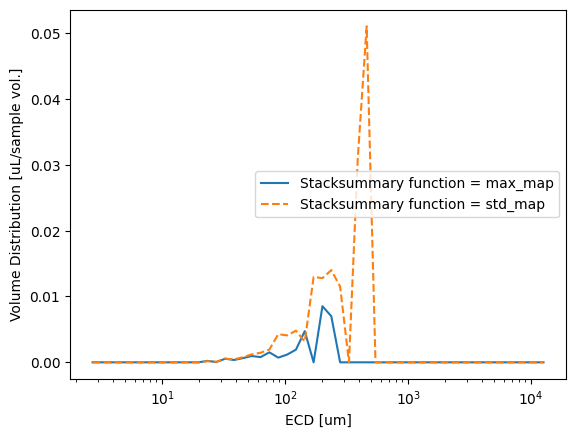

In [11]:
dias, vd = pyopia.statistics.vd_from_stats(xstats, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])

plt.plot(dias, vd, label=f"Stacksummary function = {pyopia.pipeline.steps_from_xstats(xstats)['steps']['focus']['stacksummary_function']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')

dias_modified, vd_modified = pyopia.statistics.vd_from_stats(xstats_modified, pyopia.pipeline.steps_from_xstats(xstats_modified)['general']['pixel_size'])

plt.plot(dias_modified, vd_modified, '--', label=f"Stacksummary function = {pyopia.pipeline.steps_from_xstats(xstats_modified)['steps']['focus']['stacksummary_function']}")

plt.legend()
plt.show()